## Imports and Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set font size of plot elements\n",
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def photons_from_temp(ω_c, temp):
    hbar_ov_k = 7.639e-12
    return (np.exp(hbar_ov_k * ω_c / temp) - 1) ** -1

In [4]:
def temp_from_photons(ω_c, num_photons):
    hbar_ov_k = 7.639e-12 
    return hbar_ov_k * ω_c / np.log(1 / num_photons + 1)

In [5]:
def mean_photons_cavity(κ, ω_c, Q, r, g, nT, nc):
    """
    function for calculating the steady state photon number in the cavity per equation 98 in Kurt's supplemental info document
    """
    num = (κ + ω_c / Q) * nT + r * g ** 2 / ((r/2)**2 + (r/2)*((κ+ω_c / Q) / 2) + g ** 2) * nc
    den = (κ + ω_c / Q) + r * g ** 2 / ((r/2)**2 + (r/2)*((κ+ω_c / Q) / 2) + g ** 2)
    return num / den

## Cooling Power

From what I could tell, the cooling power of different cyrogenic technologies is how much heat power is removed at a given temperature.  As an example, for dilution refrigerators with liquid Helium, this is given by the difference in enthalpy of mixing phases of He at a specific temperature.  According to Kurt, the rate of photons coming into the cavity from the thermal bath is just the output coupling rate $\kappa$ multiplied by the mean number of photons in the thermal bath $n_T$.  (Question - Matt and Ethan mentioned that $\kappa$ can often be set to 0.  Doesn't that mean that we would get worse cooling power?)

In [6]:
# First calculate the number of photons in the thermal bath at say 77 K
T = 5
ωc = 2.87 * 2 * np.pi * 1e9
nT = photons_from_temp(ωc, T)

In [7]:
# Now calculate the power associated with these photons
# This is just the energy times the rate - κ
Q = 2.5e4
γ = ωc / Q
energy = 6.626e-34 * ωc / (2 * np.pi)
pow = energy * γ
print("Energy: ", energy, " J")
print("Cooling power: ", pow, " W")

Energy:  1.9016620000000002e-24  J
Cooling power:  1.3716871958789768e-18  W


### Power consumption
According to Hanfeng, the optical excitation rate $\gamma_{opt}$ is given by
$\gamma_{opt} = P / \hbar\omega / A * \sigma_A$,
where $P$ is the power, $A$ is the area of the laser light, and $\sigma_A$ is the cross-section of the NV center.  Then the polarization is given by
$p = 0.29\gamma_{opt} / (3\gamma_{th} + 0.38\gamma_{opt})$
where $\gamma_{th} \sim 90 s^{-1}$ is the thermalization rate.  So, we can calculate the power required to achieve a desired steady-state polarization.

In [8]:
# Seems that this is unnecessary given what Hanfeng said, but I'll keep it here in case it ends up being useful later.
ρ = 300 # ppb
Vd = 0.3 * 0.3 * 0.05 # cm^3
N = ρ * 1e-9 * 3.53 * Vd / 12.01 * 6.022e23
print("Number of NVs: %3e" % N)

Number of NVs: 2.389496e+14


In [9]:
# First define the desired polarization.
p = 0.2

According to Jormala et al., at low temperatures, the relaxation time $\frac{1}{T_1} = A_1(S) + \frac{A_2}{e^{\Delta/k_bT}-1} + A_3T^5$,
where $A_2 = 2.1\times 10^3 s^{-1}$, $A_3 = 2.2\times 10^{-11} K^{-5}s^{-1}$, and $\Delta = 734$ meV.  $A_1(S)$ depends on the concentration of the spins in the sample.    They report that for a concentration of 0.3 ppm, $A_1 = 0.06 s^{-1}$.  This is the closest to the concentration we have of 0.8 ppm, so we can use it as an estimate.

In [10]:
a1 = 0.06
a2 = 2.1e3
a3 = 2.2e-11
δ = 734e6
inv_T1 = a1 + a2 / (np.exp(δ / (8.6e-5 * T)) - 1) + a3 * T ** 5
γ_th = 0.5 * inv_T1
print("γ_th: ", γ_th)
γ_opt = 3 * γ_th * p / (0.29 - 0.38 * p)
print("γ_opt: ", γ_opt)

γ_th:  0.030000034374999998
γ_opt:  0.08411224591121495


/tmp/ipykernel_1395980/3975627705.py:5: RuntimeWarning: overflow encountered in exp
  inv_T1 = a1 + a2 / (np.exp(δ / (8.6e-5 * T)) - 1) + a3 * T ** 5


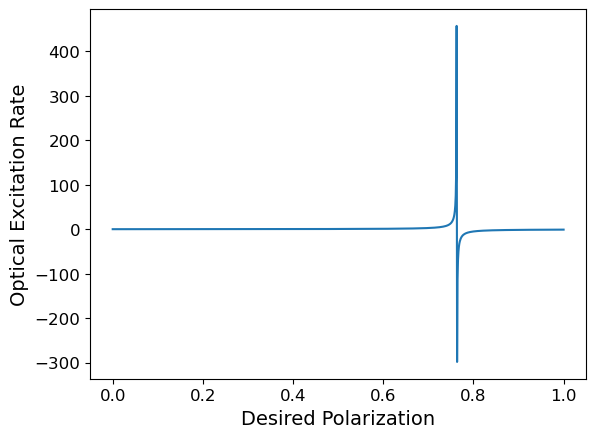

In [11]:
temp_p = np.linspace(0, 1, 1000)
temp_γ_opt = 3 * γ_th * temp_p / (0.29 - 0.38 * temp_p)
plt.plot(temp_p, temp_γ_opt)
plt.xlabel("Desired Polarization")
plt.ylabel("Optical Excitation Rate")
plt.savefig("optical_excitation_rate_vs_polarization.png", format='png', dpi=300)

In [12]:
# The cross-section is 
σ_a = 3e-17 #cm^2

In [13]:
# for a 532 nm laser, the energy per photon is
h = 6.626e-34
c = 3e8
λ = 532e-9
Ep = h * c / λ # J

In [14]:
# If we assume that the diamond is oriented so that the thin edge is along the direction of propagation of the laser, the area the laser
# should cover is 0.3 * 0.3 cm^2
A = 0.3 * 0.3  # cm^2

In [15]:
# So the power is
P = γ_opt * Ep * A / σ_a
print("P = %3e W" % P)

P = 9.428477e-05 W


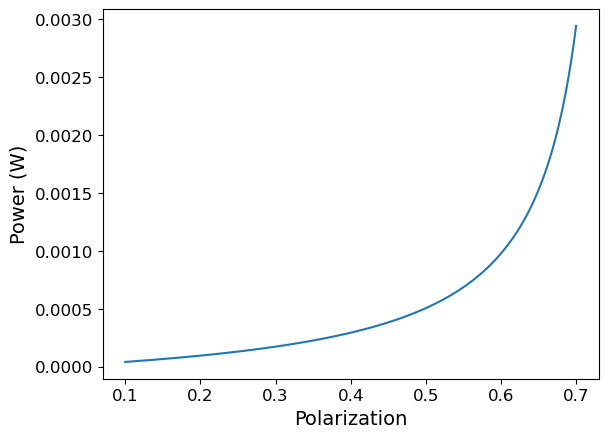

In [16]:
# Now we'll plot the laser power required to reach different polarizations
p = np.linspace(0.1, 0.7, 1000)
γ_opt = 3 * γ_th * p / (0.29 - 0.38 * p)
P = γ_opt * Ep * A / σ_a
plt.plot(p, P)
plt.xlabel("Polarization")
plt.ylabel("Power (W)")
plt.savefig("power_vs_polarization.png", format='png', dpi=300)

In [17]:
# Let's use this polarization to calculate the final temperature and plot that against the input power
# First define parameters
ωc = 2.87 * 2 * np.pi * 1e9
κ = 1
Q = 2.5e4
γ = ωc / Q
g = 1e7
r = g
T = 5
nc = 0.5 * (1 - p) / p
nT = photons_from_temp(ωc, T)
print(γ)

721309.6732642166


In [18]:
n = mean_photons_cavity(κ, ωc, Q, r, g, nT, nc)
t = temp_from_photons(ωc, n)

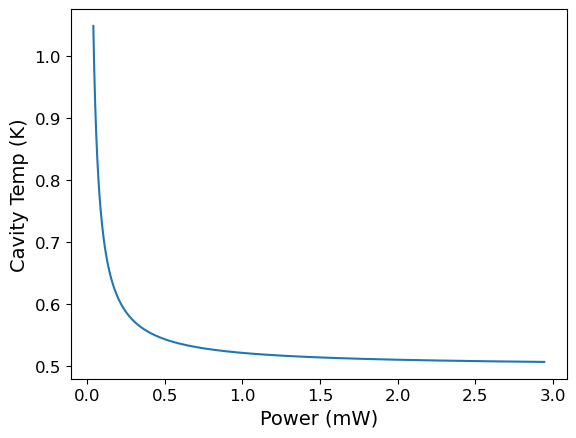

In [19]:
fig = plt.figure(1)
ax = fig.subplots(1, 1)
ax.plot(P*1e3, t)
ax.set_xlabel("Power (mW)")
ax.set_ylabel("Cavity Temp (K)")
fig.savefig("cavity_temp_vs_power.png", format='png', dpi=300)

#ax2 = ax.twiny()
#ax2.plot(p, t, 'g-')
#ax2.set_xlabel("Polarization")

I still have not managed to find the attenuation factor of diamond or the NV ensemble.  This would increase the power required to achieve a certain polarization as it will introduce a minimum power required to pass entirely through the ensemble.  I also have not had much luck determining how to calculate the required power from the Rabi oscillations, which Kurt suggested I use.  That might give a different answer for the required power and might allow us to circumvent the singularity in Hanfeng's approach.